In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("q2.ipynb")

# Qiskit Assignment 2

## Elitzur-Vaidman Bomb

### Learning Objectives
1. Implement the EV Bomb experiment
2. Run the experiment on an IBM quantum computer

### Resources
Qiskit assignments are designed to be collaborative and open internet. Where possible, links to useful documentation will be embedded within questions. You're free to discuss these tasks with TAs and peers, but do write your own solutions. For some questions, there may be additional restrictions on the ways you can solve them. To ensure compliance with course policies and assignment instructions, we reserve the right to inspect your code.

**NAME**: Sam Schwartz

**STUDENT ID**: 488082

In [2]:
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import re

#### Task 1 - Establishing the Required Iterations (10 pts)
First let's compute the number of iterations through the loop we need to be arbitrarily confident that there won't be an explosion during our experiment. 
- write a function `compute_iterations` that takes an input `probability`, *in decimal form*
- return `n`, the number of iterations needed to be (`probability`$\times 100$)% confident that there will **not** be an explosion
- round $n$ to the nearest integer 

In [89]:
def compute_iterations(probability):
    ## p= pi/4n
    ## pi/1-p = 4n; 
    n = (((np.pi)**2)/((1-probability)*4))
    round(n)
    return round(n)

In [90]:
grader.check("Task 1")

Task 1 results: All test cases passed!

#### Task 2 - Computing Theta (10 pts)
We know the number of iterations we need to be arbitrarily confident the bomb won't explode. Now let's calculate the angle we need to rotate through at each step of iteration, $\theta$. 
- write a function `compute_theta` that takes `n` as input
- return $\theta$, rounded to the nearest `5` decimal places.

In [97]:
def compute_theta(n):
    theta = np.pi/n
    theta = round(theta,5)
    #print (round(theta,5))
    return theta

In [98]:
grader.check("Task 2")

Task 2 results: All test cases passed!

#### Task 3 - Rotation (10 pts)
- write a function `rotate` that takes an input QuantumCircuit `qc` and an input `theta`
- rotate the state on the first qubit by `theta` radians about the $y$-axis of the Bloch sphere
- return the modified circuit

In [117]:
def rotate(qc, theta):
    qc.ry(theta, 0)
    return qc

In [118]:
grader.check("Task 3")

Task 3 results: All test cases passed!

We provide the below method `bomb_oracle` to randomly decide to include a bomb or not in our experiment.

In [239]:
random.seed(468)

def bomb_oracle():
    if random.random() < 0.5:
        return "bomb"
    else:
        return "empty"

<!-- BEGIN QUESTION -->

#### Task 4  - Putting Things Together (40 pts)
We are now ready to build the full circuit.
- complete the function `gen_circuit` which takes in (1) a probability that the bomb \*won't\* explode and (2) a string "bomb" or "empty"
- return a circuit representing the standard EV bomb implementation 

For our experiment, we will represent the presence of a bomb with a measurement and its absence with an [identity gate](https://qiskit.org/documentation/tutorials/circuits/3_summary_of_quantum_operations.html#Identity-gate). At the end of the circuit, remember to perform a final measurement to the result bit.

**Hints**: 
- use the previous tasks to help build your circuit
- make sure to consider both the `bomb` and `empty` cases
- in the case of a bomb, perform trial measurements to a distinct `step` bit
- refer to the end of the `08` lecture for a description of the implementation

In [296]:
def gen_circuit(probability, bomb):
    n = compute_iterations(probability)
    qc = QuantumCircuit(QuantumRegister(1,'qr'), 
                        ClassicalRegister(n, 'step'), 
                        ClassicalRegister(1, 'result')
                       )
    theta = compute_theta(n)
    for x in range(n):
        rotate(qc, theta)
        if bomb == "bomb":
            qc.measure(0,x)
    qc.measure(0,n)
    if bomb == "empty":
        qc.id(0)
        qc.measure(0,n)
        return qc
    return qc

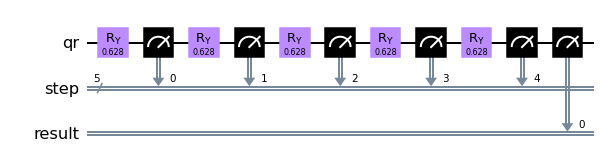

In [297]:
# Draw a bomb circuit here having probability == 0.5
# USE MATPLOTLIB FORMAT
gen_circuit(.5, "bomb").draw(output='mpl')


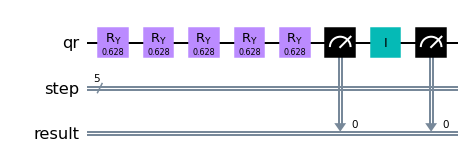

In [298]:
# Draw an empty circuit here having probability == 0.5
# USE MATPLOTLIB FORMAT
gen_circuit(.5, "empty").draw(output='mpl')

<!-- END QUESTION -->

For the next task, run the code below a few times and observe the output. 

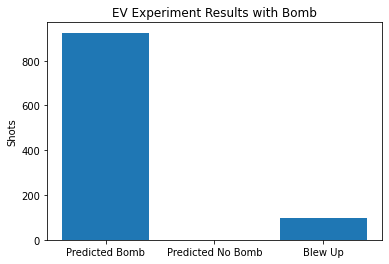

In [314]:
qasm_sim = BasicAer.get_backend("qasm_simulator")

def em(qc, shots=1024):
    job = execute(qc, qasm_sim, shots=shots)
    counts = job.result().get_counts()
    return counts

def run_circuit(percentage,bomb):
    qc = gen_circuit(percentage,bomb)
    counts = em(qc)
    n = compute_iterations(percentage)
    
    zeros_key = "0 " + "0"*n
    one_key = "1 "+"0"*n
    
    predicted_bomb = 0
    predicted_no_bomb = 0
    blew_up = 0

    if zeros_key in counts:
        predicted_bomb = counts[zeros_key]
    if one_key in counts:
        predicted_no_bomb = counts[one_key]
        
    blew_up = 1024 - predicted_bomb - predicted_no_bomb
    
    y = np.arange(3)
    plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
    plt.ylabel("Shots")
    plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
    if bomb == "bomb":
        plt.title("EV Experiment Results with Bomb")
    else:
        plt.title("EV Experiment Results with No Bomb")
    plt.show()
    
    return None

bomb = bomb_oracle()
run_circuit(0.9, bomb)

<!-- BEGIN QUESTION -->

#### Task 5  - Testing your Circuit (10 pts)
- what does measuring $|0\rangle$ or $|1\rangle$ each tell us about the the presence or absence of a bomb?
- does your circuit blow up a reasonable percentage of the time? (What would be a reasonable percentage?)

Be sure to save a chart in your notebook that shows this ratio for a "bomb" circuit. Describe it in your response below.

 My circuit does blow up a somewhat resonable % of the time. When there is a bomb present it blows up around 100 times, which makes sense given the probabilty of .9 that the bomb won't explode. Otherwise, the circuit will predict abomb and no explosion will occur (this occurs ~900 times.) With no bomb the circuit will alwyas predict no bomb and that is reflected by the graph. With a bomb the circuit will predcit a bomb about 90% of the time, otherwise it will blow up. Measuring a state of 0 or 1 doesn't nessecarily tell us anything about the presence or abscence of the bomb. If there is a bomb and we predict it and it doesn't explode state 0 should be returned, whereas if there is an explosion state 1 should be.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

#### Task 6 (6A, 6B) - EV Bomb on an IBM Quantum Computer (20 pts)
Finally, let's run this circuit on a real quantum computer. Hopefully it doesn't blow up ;)
- set the experiment probability to be `0.9`
- ensure the presence of a `bomb`
- store the measurement results in `counts`

**Note**: Do **not** use the ibmq_armonk backend for this task.

ibmqfactory.load_account:WARNING:2022-02-12 10:30:14,675: Credentials are already in use. The existing account in the session will be replaced.


Check job status here: https://quantum-computing.ibm.com/jobs/6207e09a72fcf83a43a1551a


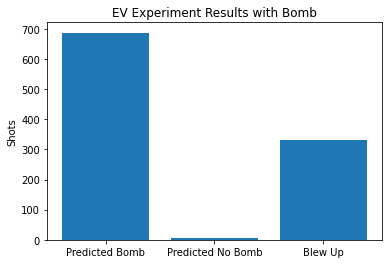

In [315]:
# run your circuit here
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
ibmqc = provider.get_backend('ibmq_quito')
job = execute(gen_circuit(.9, "bomb"), ibmqc, shots=1024)
print("Check job status here:", "https://quantum-computing.ibm.com/jobs/" + job.job_id())
res = job.result()
counts = res.get_counts()

# no need to edit any of this code below...
n = compute_iterations(.9)
zeros_key = "0 " + "0"*n
one_key = "1 "+ "0"*n

predicted_bomb = 0
predicted_no_bomb = 0
blew_up = 0

if zeros_key in counts:
    predicted_bomb = counts[zeros_key]
if one_key in counts:
    predicted_no_bomb = counts[one_key]

blew_up = 1024 - predicted_bomb - predicted_no_bomb

y = np.arange(3)
plt.bar(y, [predicted_bomb, predicted_no_bomb, blew_up])
plt.ylabel("Shots")
plt.xticks(y, ["Predicted Bomb", "Predicted No Bomb", "Blew Up"])
plt.title("EV Experiment Results with Bomb")
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

Did your circuit blow up a reasonable percentage of the time on the quantum computer? Save a chart in your notebook that shows this ratio and describe it in your response below. Was there any difference between the simulator and quantum computer results? If there was, what might account for it?

My circuit blew up significantly more on the quantum computer, but this is definitely understandable as we know the IBM quantum computers deal with interference among other issues that cause imperfect performance. There was a significant difference between the two, as the simulator predicted bomb ~90% and blew up ~10%, whereas the Quantum Computer predicted bomb ~60%, blew up ~39% and somehow predicted no bomb ~1%. This could be attributed to interference during Quantum operations which could cause imperfect/unrealistic results on a non-optimized machine

<!-- END QUESTION -->

Next time: multi-qubit circuits!

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [317]:
grader.check_all()

Task 1 results: All test cases passed!

Task 2 results: All test cases passed!

Task 3 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [318]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)